In [1]:
%autosave 0
import pandas as pd
from pandas import read_csv, DataFrame
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import metrics, optimizers, regularizers

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


In [2]:
# Import data
df = pd.read_csv("../Data/app_hover_public.csv")
pd.set_option('display.max_columns', 50)
df.sample(5)

,Steam_id,Title,Date_release,Evaluation,Nb_Eval,Nb_game_tags,Game_Tag_1,Game_Tag_2,Game_Tag_3,Game_Tag_4,Game_Tag_5,App_cat,Dev_team,Publisher_team,Os_supported,Prymary_genre,Controller_support,Is_free_app,Nb_language,Workshop_visible,Only_vr_support,Vr_support,Has_adult_content,Nb_achievements,Single_player,Coop_player,Multi_player,Early_Access,Price
10463,408450,Last Days of Spring Soundtrack,2015-10-07,No,0,3,Simulation,Great Soundtrack,Female Protagonist,NaN,NaN,Downloadable Content,Sapphire Dragon Productions,Sapphire Dragon Productions,1,Simulation,0,0,2,0,0,0,0,0,1,0,0,0,1.99
11936,436170,Parasite Demo,2016-01-19,No,0,3,Action,Adventure,Indie,NaN,NaN,Demo,Raphael Gervaise,Raphael Gervaise,4,Action,1,0,1,0,0,0,0,0,1,0,0,0,0.00
41000,933400,Multibombers - Supporter Pack,2018-08-29,No,0,5,Strategy,Action,Indie,Casual,Free to Play,Downloadable Content,Pig s Indie Games,Pig s Indie Games,4,Action,1,0,9,0,0,0,0,0,0,0,1,0,0.00
17673,537750,Dungeon Of Doom Puzzle,2016-10-28,No,0,7,Adventure,Indie,Puzzle,Difficult,Atmospheric,Game,Codespace,Codespace,1,Indie,0,0,1,0,0,0,0,0,1,0,0,0,1.99
23677,632190,Invisigun Heroes - Soundtrack,2017-09-13,No,0,5,Indie,Casual,Strategy,Action,Free to Play,Downloadable Content,Sombr Studio,Sombr Studio,4,Action,1,0,1,0,0,0,0,0,1,0,1,0,3.99


In [3]:
df.shape

(59472, 29)

In [4]:
def apply_status_reco(df):
    if df['Nb_Eval'] >= 1:
        return 1
    else:
        return 0
    
def apply_value_reco(df):
    """create Output phase 2 """
    if 'Positive' in df['Evaluation']:
        return 1
    else:
        return 0  

In [5]:
df['status_reco'] = df.apply(apply_status_reco, axis=1)
df['Value_reco'] = df.apply(apply_value_reco, axis=1)

In [6]:

df_clean = df.drop(columns=['Steam_id','Title', 'Date_release',
                            'Game_Tag_1','Game_Tag_2', 'Game_Tag_3', 'Game_Tag_4', 'Game_Tag_5',
                           'Nb_game_tags'])

In [7]:
df_clean = df_clean[df_clean["App_cat"].isin(["Game", "Downloadable Content",  "Demo"])]

In [8]:
df_clean['exp_dev_team'] = df_clean.groupby('Dev_team')['Dev_team'].transform('count')
df_clean['exp_publish_team'] = df_clean.groupby('Publisher_team')['Publisher_team'].transform('count')

In [9]:
def apply_self_editing(df):
    """create feature self editing """
    if df['Dev_team'] == df['Publisher_team']:
        return 1
    else:
        return 0

In [10]:
df_clean['Self_editor'] = df_clean.apply(apply_self_editing, axis=1)

In [11]:
values = {'exp_dev_team': 0, 'exp_publish_team': 0, 'Prymary_genre': 'Unknown Genre', 'App_cat': 'Unknown'}
df_clean = df_clean.fillna(value=values);

In [12]:
df_clean = df_clean.drop(columns=['Dev_team','Publisher_team'])

In [13]:
convert_to_bool = ["Controller_support","Is_free_app","Workshop_visible","Only_vr_support",
                   "Vr_support","Has_adult_content",'Single_player',
                  'Coop_player', 'Multi_player', 'Early_Access','Self_editor']

for col in convert_to_bool:
    df_clean[col] = df_clean[col].astype('bool')

In [14]:
df_ph1 = df_clean.drop(columns=["Evaluation", "Nb_Eval", "Value_reco"])

In [15]:
df_ph1.columns

Index(['App_cat', 'Os_supported', 'Prymary_genre', 'Controller_support',
       'Is_free_app', 'Nb_language', 'Workshop_visible', 'Only_vr_support',
       'Vr_support', 'Has_adult_content', 'Nb_achievements', 'Single_player',
       'Coop_player', 'Multi_player', 'Early_Access', 'Price', 'status_reco',
       'exp_dev_team', 'exp_publish_team', 'Self_editor'],
      dtype='object')

In [16]:
# sélection des colonnes 3 à 12 inclus pour le train
X_train_full = df_ph1.drop(columns=['status_reco'])

# sélection de la colonne 'Exited' y a prédire
y_train_full = df_ph1['status_reco']

In [17]:
X_train_full.shape,y_train_full.shape

((54447, 19), (54447,))

In [18]:
seed = 69
np.random.seed(seed)

X_train, X_test, y_train, y_test = train_test_split(X_train_full, y_train_full, test_size = 0.2, random_state = seed)

In [19]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((43557, 19), (10890, 19), (43557,), (10890,))

In [20]:
# utilisation de la méthode make_column_transformer pour regrouper les différents transform en un appel.

preprocess = make_column_transformer( (OneHotEncoder(), ['App_cat', 'Prymary_genre']),
                                      (MinMaxScaler(), ['Os_supported', 'Controller_support',
       'Is_free_app', 'Nb_language', 'Workshop_visible', 'Only_vr_support',
       'Vr_support', 'Has_adult_content', 'Nb_achievements', 'Single_player',
       'Coop_player', 'Multi_player', 'Early_Access', 'Price',
       'exp_dev_team', 'exp_publish_team', 'Self_editor']))

In [21]:
X_train = preprocess.fit_transform(X_train)
X_test = preprocess.transform(X_test)

y_train = y_train.values
y_test = y_test.values

In [22]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((43557, 47), (10890, 47), (43557,), (10890,))

# Creation du modèle

In [30]:
# Astuce: pour definire le nombre de Dense dans un premier temps on peut faire la moyenne
# du nombres de features ici 13 + nb output ici 1 soit (13+1)/2 = 7

def create_deep_classifier(neurons=100):
    
    dim = X_train.shape[1]
    model = Sequential()
    
    # initialisation du modèle et création de la couche cachée
    model.add(Dense(neurons, input_dim=dim, activation="relu", kernel_initializer="uniform"))
    model.add(Dropout(rate=0.01))
    
    # création d'une deuxiéme couche cachée
    model.add(Dense(int(neurons/2), activation="relu", kernel_initializer="uniform"))
    model.add(Dropout(rate=0.01))
    
#     model.add(Dense(int(neurons/4), activation="relu", kernel_initializer="uniform"))
#     model.add(Dropout(rate=0.01))
    
    # création de la couche de sortie
    model.add(Dense(1, activation="sigmoid", kernel_initializer="uniform"))# multi_class (3, activation="softmax")
              
    # Compilation du modèle
    model.compile(optimizer="adam", loss ="binary_crossentropy", metrics = ["accuracy"])# multi(loss="categorical_crossentropy")
    
    return model

########################## Paramétre disponible pour la creation d'une couche cachée #############################

# keras.layers.Dense(units, activation=None, use_bias=True, kernel_initializer='glorot_uniform',
#                    bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, 
#                    activity_regularizer=None, kernel_constraint=None, bias_constraint=None)
              
########################## Paramétre disponible pour la compilation d'un modèle #############################
            
# compile(optimizer, loss=None, metrics=None, loss_weights=None, 
#        sample_weight_mode=None, weighted_metrics=None, target_tensors=None)

# Entrainement du modèle

In [31]:
model = create_deep_classifier(neurons=60)
history = model.fit(X_train,y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

########################## Paramétre disponible pour l'entrainement d'un modèle #############################

# fit(x=None, y=None, batch_size=None, epochs=1, verbose=1, callbacks=None,
#     validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, 
#     initial_epoch=0, steps_per_epoch=None, validation_steps=None, validation_freq=1, 
#     max_queue_size=10, workers=1, use_multiprocessing=False)

Epoch 1/100
1362/1362 [==============================] - 4s 3ms/step - loss: 0.5454 - accuracy: 0.7097 - val_loss: 0.5282 - val_accuracy: 0.7248
Epoch 2/100
1362/1362 [==============================] - 4s 3ms/step - loss: 0.5213 - accuracy: 0.7276 - val_loss: 0.5177 - val_accuracy: 0.7312
Epoch 3/100
1362/1362 [==============================] - 4s 3ms/step - loss: 0.5140 - accuracy: 0.7346 - val_loss: 0.5142 - val_accuracy: 0.7383
Epoch 4/100
1362/1362 [==============================] - 4s 3ms/step - loss: 0.5076 - accuracy: 0.7399 - val_loss: 0.5165 - val_accuracy: 0.7331
Epoch 5/100
1362/1362 [==============================] - 4s 3ms/step - loss: 0.5042 - accuracy: 0.7423 - val_loss: 0.5035 - val_accuracy: 0.7469
Epoch 6/100
1362/1362 [==============================] - 4s 3ms/step - loss: 0.4997 - accuracy: 0.7445 - val_loss: 0.4999 - val_accuracy: 0.7513
Epoch 7/100
1362/1362 [==============================] - 3s 3ms/step - loss: 0.4961 - accuracy: 0.7454 - val_loss: 0.5013 - val_ac

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 60)                2880      
_________________________________________________________________
dropout_3 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 30)                1830      
_________________________________________________________________
dropout_4 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 31        
Total params: 4,741
Trainable params: 4,741
Non-trainable params: 0
_________________________________________________________________


In [33]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


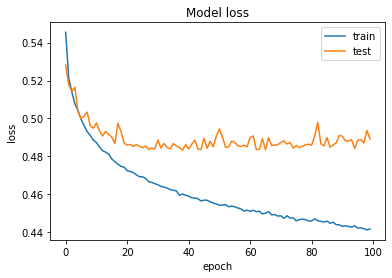

In [34]:
def hist_foll(metrics):
    plt.plot(history.history[f'{metrics}'])
    plt.plot(history.history[f"val_{metrics}"])
    plt.grid = True
    plt.title(f'Model {metrics}')
    plt.ylabel(f'{metrics}')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show

hist_foll('loss')    